### Введение
### Сборный проект-4
Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных
Данные лежат в папке /datasets/image_search/ или доступны по ссылке.

В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
Имя файла изображения.
Идентификатор описания.
Доля людей, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание не соответствует изображению.
В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

Имя файла изображения.
Идентификатор описания.
3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке test_images содержатся изображения для тестирования модели.

## Загрузка данных

### Импорт библиотек

In [ ]:
import torchvision.models as models
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import random as rd

from PIL import Image
import os

import spacy
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from math import ceil

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
from torchvision import transforms
from tensorflow import keras
from tensorflow.keras.layers import Dense
from random import randrange
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

### Загрузка и просмотр данных  

In [ ]:
DATA_PATH = '/content/dsplus_integrated_project_4/to_upload/'

In [ ]:
df = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))
df.columns = ['file_name', 'query_id', 'query_text']

In [ ]:
df.head()

file_name                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [ ]:
df.duplicated().sum()

np.int64(0)

В таблице 5822 строки. Пропусков и дубликатов нет.

In [ ]:
print('В датасете', len(df['query_id'].unique()), 'уникальных текстов запросов.')
print('В датасете', len(df['file_name'].unique()), 'уникальных имен файлов.')

В датасете 977 уникальных текстов запросов.
В датасете 1000 уникальных имен файлов.


In [ ]:
#Сохраним в переменную images_df уникальные имена файлов изображений,
# а в переменную queries_df - уникальные id и тексты запросов.
images_df = pd.DataFrame(df['file_name']).drop_duplicates('file_name').reset_index(drop=True)
queries_df = df[['query_id', 'query_text']].drop_duplicates().reset_index(drop=True)

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def lemmatize_text(df):
    df['lem_query_text'] = df['query_text'].\
    apply(lambda text: " ".join([token.lemma_ for token in nlp(text)]))
    return df

In [ ]:
queries_df = lemmatize_text(queries_df)
queries_df.head()

query_id  \
0  2549968784_39bfbe44f9.jpg#2   
1  2718495608_d8533e3ac5.jpg#2   
2  3181701312_70a379ab6e.jpg#2   
3  3207358897_bfa61fa3c6.jpg#2   
4  3286822339_5535af6b93.jpg#2   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A girl wearing a yellow shirt and sunglasses s...   
2    A man sleeps under a blanket on a city street .   
3  A woman plays with long red ribbons in an empt...   
4         Chinese market street in the winter time .   

                                      lem_query_text  
0  a young child be wear blue goggle and sit in a...  
1   a girl wear a yellow shirt and sunglasse smile .  
2     a man sleep under a blanket on a city street .  
3  a woman play with long red ribbon in an empty ...  
4         chinese market street in the winter time .

In [ ]:
#загрузим данные, полученные с помощью краудсорсинга
train_crowd_target = pd.read_table(DATA_PATH+'CrowdAnnotations.tsv',
                                   names=['file_name',
                                          'query_id',
                                          'target_crowd',
                                          'num_votes_up',
                                          'num_votes_down'])
train_crowd_target.head()

file_name                     query_id  target_crowd  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2           0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2           0.0   

   num_votes_up  num_votes_down  
0             3               0  
1             0               3  
2             0               3  
3             0               3  
4             0               3

In [ ]:
train_crowd_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   target_crowd    47830 non-null  float64
 3   num_votes_up    47830 non-null  int64  
 4   num_votes_down  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [ ]:
train_crowd_target.duplicated().sum()

np.int64(0)

Пропусков и явных дубликатов нет.

In [ ]:
print('В таблице', len(train_crowd_target['file_name'].unique()), 'уникальных имен файлов.')
print('В таблице', len(train_crowd_target['query_id'].unique()), 'уникальных текстов запросов.')

В таблице 1000 уникальных имен файлов.
В таблице 1000 уникальных текстов запросов.


In [ ]:
#загрузим данные с разметкой, полученные с помощью экспертной оценки
train_expert_target = pd.read_table(DATA_PATH+'ExpertAnnotations.tsv',
                                   names=['file_name',
                                          'query_id',
                                          'eval_1',
                                          'eval_2',
                                          'eval_3'])

train_expert_target.head()

file_name                     query_id  eval_1  eval_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2       1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2       1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2       1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2       1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2       1       1   

   eval_3  
0       1  
1       2  
2       2  
3       2  
4       2

In [ ]:
train_expert_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5822 non-null   object
 1   query_id   5822 non-null   object
 2   eval_1     5822 non-null   int64 
 3   eval_2     5822 non-null   int64 
 4   eval_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [ ]:
train_expert_target.describe()

eval_1       eval_2       eval_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

In [ ]:
print('В таблице', len(train_expert_target['file_name'].unique()), 'уникальных имен файлов.')
print('В таблице', len(train_expert_target['query_id'].unique()), 'уникальных текстов запросов.')

В таблице 1000 уникальных имен файлов.
В таблице 977 уникальных текстов запросов.


**Выводы по разделу:**
Данные загружены. Явных дубликатов и пропусков нет.

## Предобработка данных

In [ ]:
#удалим строки, в которых у всех трех экспертов разделились мнения
train_expert_target.loc[(train_expert_target['eval_1'] != train_expert_target['eval_2']) &
                        (train_expert_target['eval_2'] != train_expert_target['eval_3']) &
                        (train_expert_target['eval_3'] != train_expert_target['eval_1']), 'file_name'].count()

train_expert_target = train_expert_target.drop(
    train_expert_target[(train_expert_target['eval_1'] != train_expert_target['eval_2']) &
                        (train_expert_target['eval_2'] != train_expert_target['eval_3']) &
                        (train_expert_target['eval_3'] != train_expert_target['eval_1'])].index
)

In [ ]:
#приведем оценки экспертов к нашей единой шкале - от 0 до 1
def most_votes(df):

    df['target_experts'] = 0

    df.loc[(df['eval_1'] == df['eval_2']) & (df['eval_2'] == df['eval_3']), 'target_experts'] = \
    ((df['eval_1'] - 1) / 3).round(4)

    df.loc[df['target_experts'] == 0, 'target_experts'] = ((df['eval_2'] - 1) / 3).round(4)

    return df

train_expert_target = most_votes(train_expert_target)
train_expert_target.head()

<ipython-input-22-a1d0c70a8730>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.     0.     0.     ... 0.     0.     0.6667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['eval_1'] == df['eval_2']) & (df['eval_2'] == df['eval_3']), 'target_experts'] = \


file_name                     query_id  eval_1  eval_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2       1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2       1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2       1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2       1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2       1       1   

   eval_3  target_experts  
0       1          0.0000  
1       2          0.0000  
2       2          0.0000  
3       2          0.3333  
4       2          0.0000

In [ ]:
diff = []
for query_id in train_crowd_target['query_id'].unique():
    if query_id not in df['query_id'].unique():
        diff.append(query_id)

print(len(diff))

23


In [ ]:
print(len(train_crowd_target))
for query_id in diff:
    train_crowd_target = train_crowd_target.drop(
        train_crowd_target[train_crowd_target['query_id'] == query_id].index
    )
print(len(train_crowd_target))

47830
46721


In [ ]:
len(set(df['query_id'].unique()).intersection(train_crowd_target['query_id'].unique()))

977

In [ ]:
train_data = train_crowd_target.merge(train_expert_target,
                                      how='outer',
                                      on=['file_name', 'query_id']).drop(['eval_1',
                                                                          'eval_2',
                                                                          'eval_3',
                                                                          'num_votes_up',
                                                                          'num_votes_down'], axis=1)


train_data.isna().sum()

file_name             0
query_id              0
target_crowd       3438
target_experts    44463
dtype: int64

In [ ]:
train_data.head()

file_name                     query_id  target_crowd  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2           0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2           0.0   

   target_experts  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50159 entries, 0 to 50158
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       50159 non-null  object 
 1   query_id        50159 non-null  object 
 2   target_crowd    46721 non-null  float64
 3   target_experts  5696 non-null   float64
dtypes: float64(2), object(2)
memory usage: 1.5+ MB


Объединили таблицы с оценками.

In [ ]:
train_data = train_data.merge(queries_df,
                              how='inner',
                              on=['query_id'])


train_data.isna().sum()

file_name             0
query_id              0
target_crowd       3438
target_experts    44463
query_text            0
lem_query_text        0
dtype: int64

In [ ]:
train_data.head()

file_name                     query_id  target_crowd  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2           0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2           0.0   

   target_experts                                         query_text  \
0             NaN  A woman is signaling is to traffic , as seen f...   
1             NaN          A boy in glasses is wearing a red shirt .   
2             NaN   A young boy holds onto a blue handle on a pier .   
3             NaN  A woman wearing black clothes , a purple scarf...   
4             NaN  An older woman with blond hair rides a bicycle...   

                                      lem_query_text  
0  a woman be signal be to traffic , as see from ...  
1               a boy in glass be wear a red shirt .  
2    a young boy hold onto a blue handle on a pier .  
3  a woman wear black clothe , a purple scarf , a...  
4  an old woman with blond hair ride a bicycle do...

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50159 entries, 0 to 50158
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       50159 non-null  object 
 1   query_id        50159 non-null  object 
 2   target_crowd    46721 non-null  float64
 3   target_experts  5696 non-null   float64
 4   query_text      50159 non-null  object 
 5   lem_query_text  50159 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.3+ MB


Объединили общую таблицу с оценками с таблицей с текстами запросов.

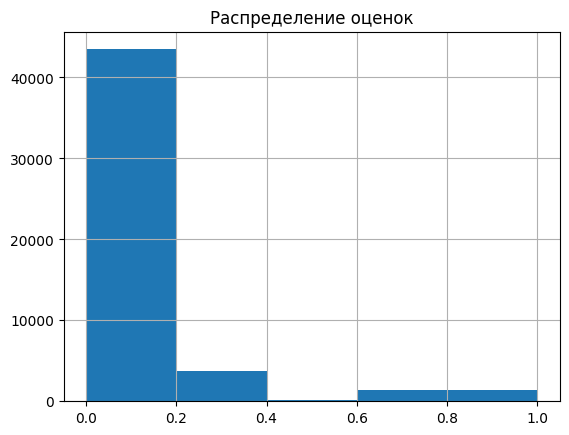

In [ ]:
#в качестве итоговой оценки в строках с пропуском в экспертной оценке возьмем оценку краудсорсинга и
#наоборот


train_data.loc[train_data['target_crowd'].isna(),'total_target'] = train_data['target_experts']
train_data.loc[train_data['target_experts'].isna(),'total_target'] = train_data['target_crowd']

#в строках с наличием обеих оценок в качестве итоговой возьмем среднее значение

train_data.loc[train_data['total_target'].isna(),
               'total_target'] = train_data[['target_experts', 'target_crowd']].mean(axis=1)

train_data = train_data.drop(['target_experts', 'target_crowd'], axis=1)


train_data['total_target'].hist(bins=5)
plt.title('Распределение оценок');

**Выводы по разделу:**

1. Большая часть оценок (порядка 44 тыс) лежат в диапазоне 0 до 0,2;
2. Часть оценок (порядка 3,5 тыс) в диапазоне от 0,2 до 0,4;
3. В диапазоне от 0,4 до 0,6 оценок нет;
4. От 0,6 до 1 оценок приблизительно 1 тыс.

## Построение модели

### Подготовка данных для модели

In [ ]:
stop_words = [
    'boy', 'girl', 'child', 'teenage', 'teenager', 'kid', 'baby',
    'infant', 'toddler', 'newborn', 'preschooler', 'adolescent',
    'juvenile', 'minor', 'orphan', 'schoolboy', 'schoolgirl',
    'youngster', 'tween', 'preteen', 'nursery', 'crib', 'stroller',
    'kindergarten', 'pediatric', 'lullaby', 'playground', 'toy',
    'storybook', 'cartoon', 'diaper', 'pacifier'
]

In [ ]:
# Функция для проверки наличия ключевых слов в описании
def contains_stop_words(row, stop_words):
    query_text = row['query_text']
    if any(stop_word in query_text.lower() for stop_word in stop_words):
        image_name = row['query_id'][:-2]
        return image_name
    else:
        return np.nan

In [ ]:
# Получаем Series с изображениями, которые не проходят проверку
images_to_remove = train_data.apply(contains_stop_words, axis=1, args=(stop_words,)).dropna(ignore_index=True)
images_to_remove

0         114051287_dd85625a04.jpg
1        1427391496_ea512cbe7f.jpg
2        2436081047_bca044c1d3.jpg
3        2490768374_45d94fc658.jpg
4        2549968784_39bfbe44f9.jpg
                   ...            
14894    2553550034_5901aa9d6c.jpg
14895    2554081584_233bdf289a.jpg
14896    3315616181_15dd137e27.jpg
14897    3456362961_d8f7e347a8.jpg
14898     543007912_23fc735b99.jpg
Length: 14899, dtype: object

In [ ]:
# Переводим Series в сет
images_to_remove_set = set(images_to_remove)

In [ ]:
# Количество изображений, которые не проходят проверку
len(images_to_remove_set)

303

In [ ]:
# Удаляем изображения из датасета train_data
train_data = train_data[~train_data['file_name'].isin(images_to_remove_set)].reset_index(drop=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35039 entries, 0 to 35038
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       35039 non-null  object 
 1   query_id        35039 non-null  object 
 2   query_text      35039 non-null  object 
 3   lem_query_text  35039 non-null  object 
 4   total_target    35039 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=42)

In [ ]:
train_indices, valid_indices = next(
    gss.split(X=train_data.drop(['total_target'], axis=1),
              y=train_data['total_target'], groups=train_data['file_name'])
)

X_train, X_valid, y_train, y_valid = (
    train_data.drop('total_target', axis=1).loc[train_indices],
    train_data.drop('total_target', axis=1).loc[valid_indices],
    train_data['total_target'].loc[train_indices],
    train_data['total_target'].loc[valid_indices]
)

print(len(X_train['file_name'].unique()))
print(len(X_valid['file_name'].unique()))
print(len(X_train['file_name']))
print(len(X_valid['file_name']))

522
175
26115
8924


In [ ]:
resnet = models.resnet18()

# заморозим веса
for param in resnet.parameters():
    param.requires_grad_(False)

# используем все слои, кроме двух последних
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

# переводим модель в режим предсказания
resnet.eval();
# приведем изображение к нужному формату
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

In [ ]:
def img_to_vect(image_name, img_folder_name):

    img = Image.open(DATA_PATH + img_folder_name + '/' + image_name).convert('RGB')
    image_tensor = preprocess(img).unsqueeze(0)
    img_vector = resnet(image_tensor).flatten().numpy()

    return img_vector

def df_img_vectorizer(df, img_folder_name):

    df['img_vector'] = df['file_name'].apply(lambda x: img_to_vect(x, img_folder_name))

    return df

In [ ]:
%%time
images_df = df_img_vectorizer(images_df, 'train_images')

CPU times: user 1min 34s, sys: 256 ms, total: 1min 34s
Wall time: 1min 35s


In [ ]:
# Словарь images_df содержит векторы для каждого изображения
display(f'Длина словаря images_df: {len(images_df)} записей')
images_df

'Длина словаря images_df: 1000 записей'

file_name  \
0    1056338697_4f7d7ce270.jpg   
1    1262583859_653f1469a9.jpg   
2    2447284966_d6bbdb4b6e.jpg   
3    2549968784_39bfbe44f9.jpg   
4    2621415349_ef1a7e73be.jpg   
..                         ...   
995  3411393875_a9ff73c67a.jpg   
996  2991994415_504d1c0a03.jpg   
997  3375991133_87d7c40925.jpg   
998  3544793763_b38546a5e8.jpg   
999  2533424347_cf2f84872b.jpg   

                                            img_vector  
0    [0.66071856, 0.6090048, 3.315575, 0.0, 1.86987...  
1    [0.53975827, 0.46957335, 3.423214, 0.0, 1.8198...  
2    [0.5523316, 0.69505006, 4.0716414, 0.0, 1.8760...  
3    [0.5868787, 0.6091809, 3.3024545, 0.0, 2.14624...  
4    [0.35810542, 0.33014652, 1.832957, 0.0, 1.0934...  
..                                                 ...  
995  [0.6072225, 0.79882306, 3.9108665, 0.0, 2.4498...  
996  [0.6229644, 0.52514756, 2.9720864, 0.0, 1.6636...  
997  [0.46886817, 0.50463206, 2.951344, 0.0, 1.6310...  
998  [0.5105563, 0.5155793, 3.7292483, 0.0, 1.92187...  
999  [0.56450963, 0.67356014, 3.100341, 0.0, 1.5588...  

[1000 rows x 2 columns]

In [ ]:
X_train = X_train.merge(images_df, on='file_name', how='left')
X_valid = X_valid.merge(images_df, on='file_name', how='left')

In [ ]:
#векторизуем тексты с помощью tf-idf
tfidf = TfidfVectorizer()
tfidf.fit(X_train['lem_query_text'].drop_duplicates());


def text_to_vect(df):
    text_features_array = tfidf.transform(df['lem_query_text']).toarray()
    return text_features_array

def make_features(df):

    # массив с векторами признаков изображений
    img_array = np.array(df['img_vector'].values.tolist())

    # массив с векторами признаков текста
    tfidf_array = text_to_vect(df)

    # объединенный массив с полным набором признаков
    features_array = np.concatenate((tfidf_array, img_array), axis=1)

    return features_array

train_features = make_features(X_train)
print(train_features.shape)

valid_features = make_features(X_valid)
print(valid_features.shape)

(26115, 1767)
(8924, 1767)


### Обучение модели

В качетсве метрики, которую будем оптимизировать, выберим MSE (Mean Squared Error). Причины следующие:

1. Чувствительность к большим ошибкам

MSE возводит ошибки в квадрат, что делает её чувствительной к крупным отклонениям. Это особенно важно, если нам критично минимизировать большие ошибки, а не просто среднюю разницу.

2. Непрерывность и дифференцируемость

MSE легко дифференцируется.

3. Широко используется в задачах регрессии

В задачах предсказания числовых значений MSE является стандартной метрикой, так как она точно оценивает среднее отклонение предсказаний от фактических значений.

4. Наказание за большие ошибки

В отличие от MAE (Mean Absolute Error), которая оценивает ошибки линейно, MSE более строго наказывает большие ошибки, что делает её подходящей, если важно снизить влияние крупных промахов модели.

**Вывод:**
MSE — оптимальный выбор, так как он позволяет модели сфокусироваться на уменьшении крупных ошибок.

In [ ]:
model_dummy = DummyRegressor()
model_dummy.fit(train_features, y_train)

predictions_dummy = model_dummy.predict(valid_features)
score_dummy = mean_squared_error(y_valid, predictions_dummy)

f'Значение метрики MSE на валидационной выборке с использованием DummyRegressor равно: {score_dummy}'

'Значение метрики MSE на валидационной выборке с использованием DummyRegressor равно: 0.04595212498997194'

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(train_features, y_train);

lin_reg_preds = lin_reg.predict(valid_features)
print(mean_squared_error(y_valid, lin_reg_preds))

0.18542975530700678


In [ ]:
%%time
best_metric = 500
for i in [50, 70, 80]:
    for j in [20, 40, 30]:
        for k in [5, 9]:

            units_4 = [i, j, k, 1]
            input_dim = train_features.shape[1]

            dense_model = keras.models.Sequential()
            dense_model.add(keras.layers.Dense(units=units_4[0], input_dim=input_dim,
                                               activation='relu'))
            dense_model.add(Dense(units=units_4[1], input_dim=units_4[0], activation='relu'))
            dense_model.add(Dense(units=units_4[2], input_dim=units_4[1], activation='relu'))
            dense_model.add(Dense(units=units_4[3], input_dim=units_4[2], activation='sigmoid'))

            dense_model.compile(loss='mean_squared_error', optimizer='Adam',
                                metrics=['mean_squared_error'])

            dense_model.fit(train_features, y_train, epochs=100,validation_data=(valid_features,
                                                                                 y_valid))

            metric = mean_squared_error(y_valid, dense_model.predict(valid_features))

            if metric < best_metric:
                best_metric = metric
                best_units = [i, j, k]
                best_dense_model = dense_model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0487 - mean_squared_error: 0.0487 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0451 - val_mean_squared_error: 0.0451
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 0.0455 - val_mean_squared_error: 0.0455
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0436 - val_mean_squared_error: 0.0436
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0444 - val_mean_squared_error: 0.0444
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0504 - mean_squared_error: 0.0504 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0451 - val_mean_squared_error: 0.0451
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0484 - mean_squared_error: 0.0484 - val_loss: 0.0447 - val_mean_squared_error: 0.0447
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - val_loss: 0.0444 - val_mean_squared_error: 0.0444
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0436 - val_mean_squared_error: 0.0436
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0536 - mean_squared_error: 0.0536 - val_loss: 0.0454 - val_mean_squared_error: 0.0454
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0455 - val_mean_squared_error: 0.0455
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0440 - val_mean_squared_error: 0.0440
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0439 - val_mean_squared_error: 0.0439
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0490 - mean_squared_error: 0.0490 - val_loss: 0.0483 - val_mean_squared_error: 0.0483
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0465 - val_mean_squared_error: 0.0465
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0441 - val_mean_squared_error: 0.0441
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0441 - val_mean_squared_error: 0.0441
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0432 - val_mean_squared_error: 0.0432
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1854 - mean_squared_error: 0.1854 - val_loss: 0.1079 - val_mean_squared_error: 0.1079
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0685 - val_mean_squared_error: 0.0685
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0662 - mean_squared_error: 0.0662 - val_loss: 0.0547 - val_mean_squared_error: 0.0547
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0533 - mean_squared_error: 0.0533 - val_loss: 0.0494 - val_mean_squared_error: 0.0494
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0484 - mean_squared_error: 0.0484 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0465 - val_mean_squared_error: 0.0465
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.0510 - val_mean_squared_error: 0.0510
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.0465 - val_mean_squared_error: 0.0465
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0475 - val_mean_squared_error: 0.0475
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0450 - val_mean_squared_error: 0.0450
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0451 - val_mean_squared_error: 0.0451
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0433 - val_mean_squared_error: 0.0433
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0526 - mean_squared_error: 0.0526 - val_loss: 0.0475 - val_mean_squared_error: 0.0475
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0498 - mean_squared_error: 0.0498 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.0447 - val_mean_squared_error: 0.0447
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0444 - val_mean_squared_error: 0.0444
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0768 - val_mean_squared_error: 0.0768
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0505 - val_mean_squared_error: 0.0505
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 0.0460 - val_mean_squared_error: 0.0460
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.0451 - val_mean_squared_error: 0.0451
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - val_loss: 0.0453 - val_mean_squared_error: 0.0453
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0487 - mean_squared_error: 0.0487 - val_loss: 0.0451 - val_mean_squared_error: 0.0451
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - val_loss: 0.0439 - val_mean_squared_error: 0.0439
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0435 - val_mean_squared_error: 0.0435
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0476 - val_mean_squared_error: 0.0476
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0463 - mean_squared_error: 0.0463 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0451 - val_mean_squared_error: 0.0451
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 0.0451 - val_mean_squared_error: 0.0451
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0443 - val_mean_squared_error: 0.0443
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.0435 - val_mean_squared_error: 0.0435
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0459 - val_mean_squared_error: 0.0459
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0566 - mean_squared_error: 0.0566 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0466 - mean_squared_error: 0.0466 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0449 - val_mean_squared_error: 0.0449
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1904 - mean_squared_error: 0.1904 - val_loss: 0.1082 - val_mean_squared_error: 0.1082
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0972 - mean_squared_error: 0.0972 - val_loss: 0.0686 - val_mean_squared_error: 0.0686
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0657 - mean_squared_error: 0.0657 - val_loss: 0.0548 - val_mean_squared_error: 0.0548
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - val_loss: 0.0494 - val_mean_squared_error: 0.0494
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0504 - mean_squared_error: 0.0504 - val_loss: 0.0472 - val_mean_squared_error: 0.0472
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 0.0454 - val_mean_squared_error: 0.0454
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.0439 - val_mean_squared_error: 0.0439
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0445 - val_mean_squared_error: 0.0445
Epoch 7/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - val_los

In [ ]:
print(best_metric)
print(best_units)

0.04267975459189034
[50, 40, 9]


In [ ]:
test_images_df = pd.read_csv(DATA_PATH + 'test_images.csv')
test_images_df.columns = ['file_name']
test_images_df.head()

file_name
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [ ]:
%%time
test_images_df = df_img_vectorizer(test_images_df, 'test_images')

test_images_df.head()

CPU times: user 9.86 s, sys: 60.1 ms, total: 9.92 s
Wall time: 11 s


file_name  \
0  3356748019_2251399314.jpg   
1  2887171449_f54a2b9f39.jpg   
2  3089107423_81a24eaf18.jpg   
3  1429546659_44cb09cbe2.jpg   
4  1177994172_10d143cb8d.jpg   

                                          img_vector  
0  [0.6380359, 0.57384205, 3.5249367, 0.0, 1.8945...  
1  [0.6685224, 0.72478557, 3.7805755, 0.0, 2.1924...  
2  [0.6194973, 0.59393746, 3.8966646, 0.0, 1.8845...  
3  [0.51436377, 0.38825324, 2.9685035, 0.0, 1.560...  
4  [0.5671301, 0.57365096, 2.9817162, 0.0, 1.6090...

In [ ]:
test_queries_df = pd.read_csv(DATA_PATH + 'test_queries.csv', sep='|')
test_queries_df.columns=['index', 'query_id', 'query_text', 'file_name']
test_queries_df.head()


test_df = test_images_df
test_df.head()

file_name  \
0  3356748019_2251399314.jpg   
1  2887171449_f54a2b9f39.jpg   
2  3089107423_81a24eaf18.jpg   
3  1429546659_44cb09cbe2.jpg   
4  1177994172_10d143cb8d.jpg   

                                          img_vector  
0  [0.6380359, 0.57384205, 3.5249367, 0.0, 1.8945...  
1  [0.6685224, 0.72478557, 3.7805755, 0.0, 2.1924...  
2  [0.6194973, 0.59393746, 3.8966646, 0.0, 1.8845...  
3  [0.51436377, 0.38825324, 2.9685035, 0.0, 1.560...  
4  [0.5671301, 0.57365096, 2.9817162, 0.0, 1.6090...

### Оценка качества модели

In [ ]:
#тестирование
def eval_query_nn(query_text):
    # лемматизируем текст запроса
    lemm_text = " ".join([token.lemma_ for token in nlp(query_text)])
    # создаем маркер наличия стоп-слова
    stop = 0
    # проверяем на наличие стоп-слов в запросе
    for word in stop_words:
        if word in lemm_text:
            stop = 1
            break

    if stop == 0:
        # лемматизируем текст
        test_df['lem_query_text'] = lemm_text
        # создаем массив признаков
        test_features = make_features(test_df)
        # получаем предсказания
        test_preds = best_dense_model.predict(test_features)
        # находим индекс иозображения с наибольшей оценкой
        img_index = np.argsort(test_preds.ravel())[::-1][0]
        # выводим изображение на экран
        display(Image.open(DATA_PATH + 'test_images/' + test_images_df.loc[img_index,
                                                                      'file_name']).convert('RGB'))
        # выодим текст запроса на экран
        print(query_text)
        # выводим оценку, которую поставила модель, на экран
        print(round(test_preds.ravel()[img_index], 3))

    else:
        # если в запросе есть стоп-слова - выводим дисклеймер
        result = print('This image is unavailable in your country in compliance with local laws.')

In [ ]:
def eval_query_lin_reg(query_text):
    # лемматизируем текст запроса
    lemm_text = " ".join([token.lemma_ for token in nlp(query_text)])
    # создаем маркер наличия стоп-слова
    stop = 0
    # проверяем на наличие стоп-слов в запросе
    for word in stop_words:
        if word in lemm_text:
            stop = 1
            break

    if stop == 0:
        # лемматизируем текст
        test_df['lem_query_text'] = lemm_text
        # создаем массив признаков
        test_features = make_features(test_df)
        # получаем предсказания
        test_preds = lin_reg.predict(test_features)
        # находим индекс иозображения с наибольшей оценкой
        img_index = np.argsort(test_preds.ravel())[::-1][0]
        # выводим изображение на экран
        display(Image.open(DATA_PATH + 'test_images/' + test_images_df.loc[img_index,
                                                                      'file_name']).convert('RGB'))
        # выодим текст запроса на экран
        print(query_text)
        # выводим оценку, которую поставила модель, на экран
        print(round(test_preds.ravel()[img_index], 3))

    else:
        # если в запросе есть стоп-слова - выводим дисклеймер
        result = print('This image is unavailable in your country in compliance with local laws.')

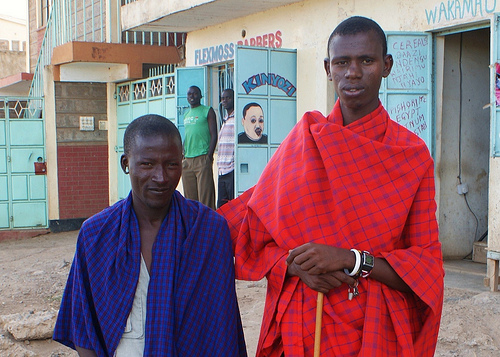

A black dog has a dumbbell in his mouth looking at the person wearing blue .
1.104
None
This image is unavailable in your country in compliance with local laws.
None


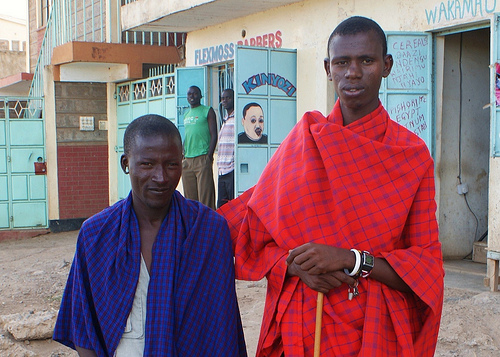

A black man in a blue shirt stands next to a black man in a red robe .
1.211
None


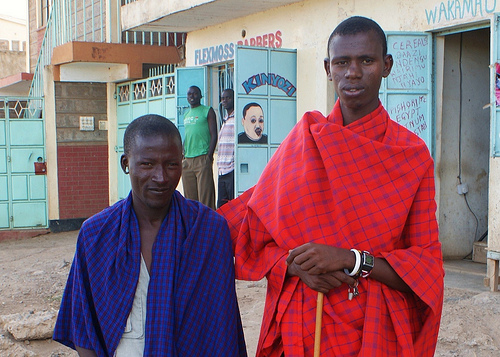

The person wearing shorts and a shirt is jumping off a dock , into the water .
1.398
None
This image is unavailable in your country in compliance with local laws.
None


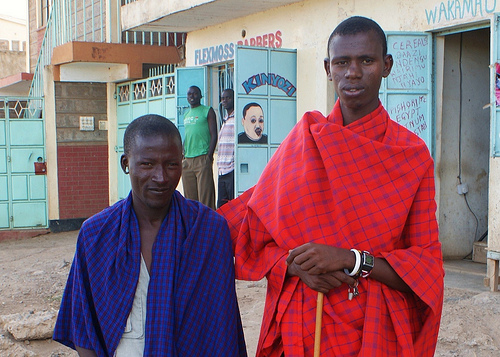

Stretched image of a brown dog with a white patch of fur in his chest area sitting in the grass with trees in the background .
1.145
None


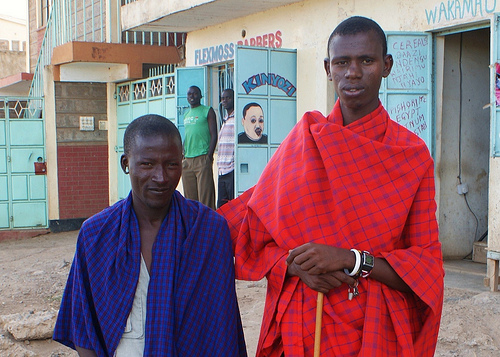

Cyclists are leaping into the air whilst being watched by spectators .
1.336
None
This image is unavailable in your country in compliance with local laws.
None
This image is unavailable in your country in compliance with local laws.
None


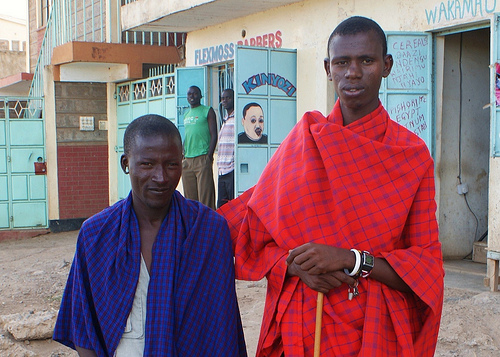

The small dog returns with his stick proudly .
1.037
None


In [ ]:
for i in range(10):
    print(eval_query_lin_reg(test_queries_df.loc[randrange(len(test_queries_df['query_text'])),
                             'query_text']))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


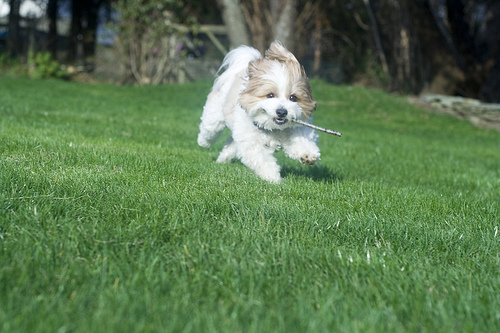

A group of men stands near a tree as a racing car stirs up a cloud of dust on the gravel road beside them .
0.029
None
This image is unavailable in your country in compliance with local laws.
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


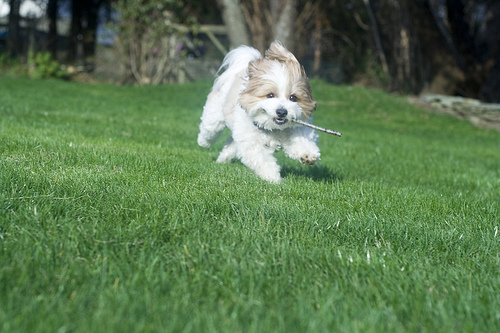

A race car kicks up dirt and dust on a gravel track .
0.108
None
This image is unavailable in your country in compliance with local laws.
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


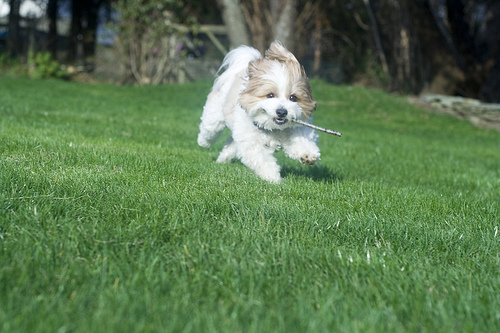

a snowboarder wearing red is descending a snow covered mountain .
0.22
None
This image is unavailable in your country in compliance with local laws.
None
This image is unavailable in your country in compliance with local laws.
None
This image is unavailable in your country in compliance with local laws.
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


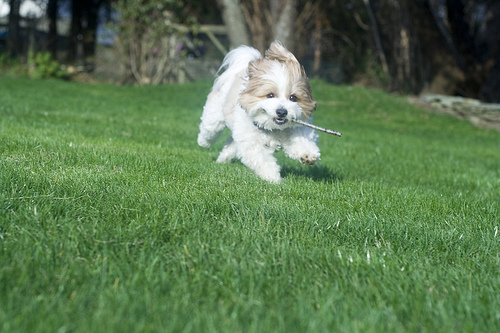

A camera man is behind his video camera and surrounded by a hudge crowd .
0.213
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


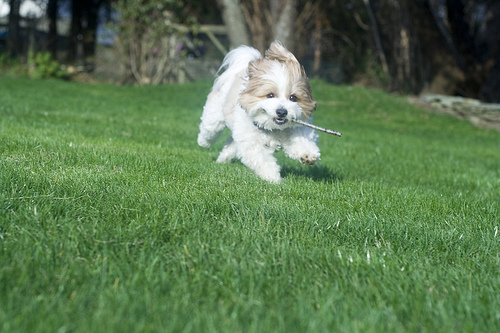

A brown dog and a black dog run into each other in the grass .
0.123
None


In [ ]:
for i in range(10):
    print(eval_query_nn(test_queries_df.loc[randrange(len(test_queries_df['query_text'])),
                        'query_text']))

### CLIP

In [ ]:
# Загрузка модели CLIP 'clip-ViT-B-32'
model_clip = SentenceTransformer('clip-ViT-B-32')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# Функция загрузки изображений из папки
def clip_encode_images_from_folder(folder):
    images = []
    image_names = []
    for filename in tqdm(os.listdir(folder), desc='Loading images'):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and filename.endswith(('.png', '.jpg', '.jpeg')):
            image = model_clip.encode(Image.open(img_path))
            images.append(image)
            image_names.append(filename)

    dataframe = pd.DataFrame(
    {'image': image_names,
     'image_vector': images
    })

    return dataframe

In [ ]:
# Загрузка изображений
test_images_encoded = clip_encode_images_from_folder(DATA_PATH + 'test_images/')
test_images_encoded.head()

Loading images: 100%|██████████| 101/101 [00:30<00:00,  3.32it/s]


image  \
0   440190907_bf8b7ba8ef.jpg   
1  3386953179_84c2d7922f.jpg   
2  3514297698_0512623955.jpg   
3  3722572342_6904d11d52.jpg   
4  3482859574_3908de3427.jpg   

                                        image_vector  
0  [-0.06315811, -0.029945672, 0.2800558, -0.2256...  
1  [-0.6106704, 0.31669062, 0.3385784, 0.4727084,...  
2  [0.3315482, 0.50295925, -0.3645091, 0.18304096...  
3  [0.5328436, -0.054188795, 0.028274555, 0.19831...  
4  [-0.19339365, -0.15111163, -0.042532735, 0.436...

In [ ]:
# Поиск изображения по описанию
def clip_find_similar(text, dataframe, image_folder_path):
    text_emb = model_clip.encode(text)
    similarity_scores = model_clip.similarity(dataframe['image_vector'], text_emb)

    max_similarity = similarity_scores.max().item()
    max_similarity_index = similarity_scores.argmax().item()

    image_name = dataframe.loc[max_similarity_index]['image']

    display(text)
    display(f'Similarity score: {max_similarity:.2f}')
    display(image_name)
    display(Image.open(os.path.join(image_folder_path, image_name)))

'Young man on a trick bicycle jumps at the top of a graffiti covered ramp .'

'Similarity score: 0.32'

'3459871361_92d1ecda36.jpg'

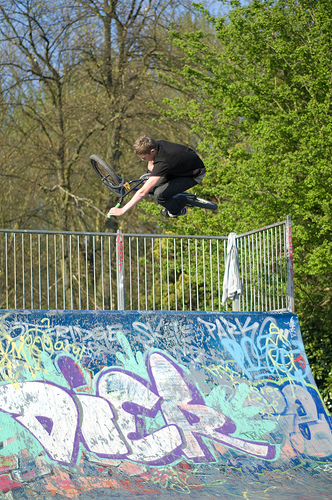

In [ ]:
# Проверяем работу модели
clip_find_similar('Young man on a trick bicycle jumps at the top of a graffiti covered ramp .', test_images_encoded, DATA_PATH + 'test_images/')

## Выводы и рекомендации

Итоговый анализ
В ходе работы были обучены модели, предназначенные для предсказания степени соответствия между текстовым запросом и изображением.

Входные данные: Коллекция из 1000 уникальных изображений. Файл с названиями изображений. Датасет с экспертной оценкой соответствия запросов и изображений (примерно 15% от общего объёма). Датасет с краудсорсинговыми оценками соответствия (около 95% всей выборки). Модели и обучение: Были протестированы два подхода: линейная регрессия и полносвязная нейросеть из четырёх слоёв. Для нейросети оптимальное число нейронов подбиралось путем тестирования различных комбинаций. Обучение длилось 100 эпох, и наилучшие результаты показала архитектура:

150 нейронов в первом слое, 50 во втором, 5 в третьем, 1 на выходе. Результаты и выводы: Обе модели продемонстрировали схожие значения ошибки MSE. На финальном тестировании были выявлены серьезные проблемы:

Линейная регрессия возвращает одно и то же изображение для всех запросов. Нейросеть не способна корректно сопоставить картинку с описанием. Возможные причины неудачи:

Ошибки в исходной разметке данных. Дисбаланс в распределении оценок (большинство приближено к нулю). Неправильный выбор модели или метрики. Рекомендации для улучшения: Провести аудит разметки и при необходимости исправить ошибки. Добавить дополнительные примеры, где текст и изображение точно соответствуют друг другу. Экспериментировать с другими типами моделей и метрик для более точного соответствия.